In [2]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu110

In [3]:
# Global Libraries
import collections
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics

# MXNet ND-Arrays with Numpy notation
mx.npx.set_np()

# Local Libraries
import model
import utils

# GPU mode
ctx = mx.gpu()

In [4]:
# python3 -m pip install pandas
# python3 -m pip install seaborn
# python3 -m pip install scikit-learn

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [5]:
if not os.path.exists("cats_dogs_light.zip"):
    !wget https://zenodo.org/record/5226945/files/cats_dogs_light.zip?download=1 -O cats_dogs_light.zip

In [9]:
# Load Dataset: Dogs vs Cats Light Version
# Full dataset available: https://www.kaggle.com/c/dogs-vs-cats
# Light version available: https://zenodo.org/record/5226945#.Y9ZYCezP3VZ
from importlib import reload
reload(utils)

path = os.getcwd()

# Variables for dataset loading & pre-processing for plotting
imageNet = False
batch_size = 32

# Pre-processing the data, splitting training, validation and test set

# For Full Dataset (25k samples)
# Training set 20k samples (80%), Val set 2500 samples (10%), Test set 2500 samples (10%)
# light=False
# split = [0.8, 0.1, 0.1]

# For light version Dataset (1000 samples for Train+Val, 400 samples for Test)
# Training set 800 samples (80%), Val set 200 samples (20%), Test set 400 samples
light=True
split = [0.8, 0.2]

if not os.path.exists("./cats_dogs_light"):
    utils.preprocess_kaggle_cats_vs_dogs(path, split, light=light)

# Generate DataLoader without pre-processing for ImageNet for visualization purposes (light dataset version)
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
train_dataldr, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(train_dataset, None, test_dataset, batch_size=batch_size)

classes = ["Cats", "Dogs"]

number_of_features = 224 * 224

In [10]:
print(val_dataset[0][0].shape)

(224, 224, 3)


Number of batches seen: 1


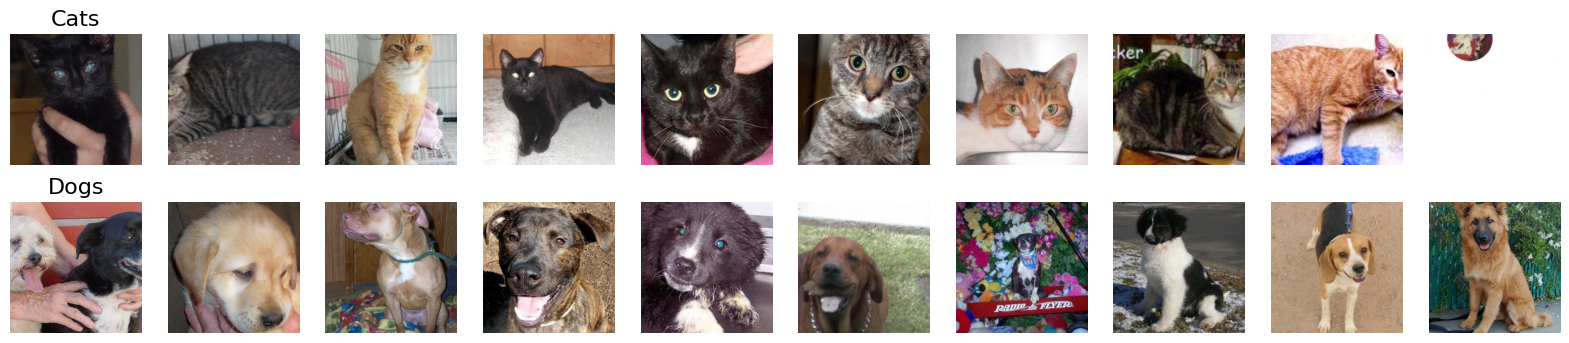

In [11]:
# Images in Grid Format

number_of_classes = len(classes)
number_of_images_per_class = 10

#fig, axes = plt.subplots(number_of_classes, number_of_images_per_class)#, figsize=(2, 20))
fig = plt.figure(figsize=(20, 4))

# Keep track of instances found
instances_per_class = {}
remaining_instances_to_be_found = set(range(number_of_classes))

# Traverse through the training set to find the 1st instances per class (number_of_images_per_class)
for iteration, (X_batch, y_batch) in enumerate(train_dataldr):    
    for X, y in zip(X_batch, y_batch):
        
        # Format inputs
        X = X.asnumpy()
        y = y.asnumpy().item()

        if y in instances_per_class and instances_per_class[y] == 10:
            if y in remaining_instances_to_be_found:
                remaining_instances_to_be_found.remove(y)
            continue
        
        if y not in instances_per_class:
            instances_per_class[y] = 0
            axes = fig.add_subplot(2, 10, y * 10 + 1)
            axes.set_title(classes[y], fontsize=16)
        else:
            axes = fig.add_subplot(2, 10, y * 10 + instances_per_class[y] + 1)

        axes.imshow(X)
        axes.axis('off')

        instances_per_class[y] += 1

    if not remaining_instances_to_be_found:
        # We are done
        break

print("Number of batches seen:", iteration + 1)

## Generate Datasets and DataLoaders (data iterators)

In [12]:
# Generate DataLoader with pre-processing for ImageNet (light dataset version)
imageNet=True
light=True
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
_, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(None, None, test_dataset, batch_size=32)

## Training from scratch

In [13]:
# Back to NumPy Semantics
mx.npx.set_np()

# ResNet50 from Model Zoo (This downloads v1d)
# No Pre-trained weights (training from scratch)
resnet50 = gcv.model_zoo.get_model("resnet50_v1d", pretrained=False, ctx=ctx, classes=2)

In [14]:
import model
reload(model)

# Define Loss Function (Binary, cats vs dogs)
# loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values for full: "adam", lr: 0.01, 10+ epochs, batch size 256
# Optimal values for light: "adam", lr: 0.0001, 10+ epochs, batch size 16
epochs = 100
batch_size = 16
resnet50.initialize(mx.init.MSRAPrelu(), ctx=ctx)

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(resnet50.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50.collect_params(), "sgd", {"learning_rate": 0.001})

training_loss, training_acc, validation_loss, validation_acc = model.training_loop(resnet50,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

[13:46:40] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.
[13:46:43] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


E:    1, TrL: 1.366326, TrAcc: 0.552500, VL: 1.030476, VAcc: 0.495000 --- Updating saved model
E:    2, TrL: 0.703976, TrAcc: 0.578750, VL: 1.608919, VAcc: 0.500000 --- Updating saved model
E:    3, TrL: 0.786262, TrAcc: 0.571250, VL: 0.783508, VAcc: 0.570000 --- Updating saved model
E:    4, TrL: 0.652810, TrAcc: 0.645000, VL: 0.804068, VAcc: 0.590000 --- Updating saved model
E:    5, TrL: 0.690763, TrAcc: 0.618750, VL: 0.722990, VAcc: 0.575000
E:    6, TrL: 0.645782, TrAcc: 0.637500, VL: 0.863458, VAcc: 0.575000
E:    7, TrL: 0.649808, TrAcc: 0.638750, VL: 0.989475, VAcc: 0.515000
E:    8, TrL: 0.647469, TrAcc: 0.652500, VL: 0.748572, VAcc: 0.565000
E:    9, TrL: 0.645721, TrAcc: 0.677500, VL: 0.745678, VAcc: 0.590000
E:   10, TrL: 0.706363, TrAcc: 0.623750, VL: 0.808589, VAcc: 0.575000
E:   11, TrL: 0.736281, TrAcc: 0.612500, VL: 1.633335, VAcc: 0.560000
E:   12, TrL: 0.696335, TrAcc: 0.588750, VL: 0.845961, VAcc: 0.575000
E:   13, TrL: 0.653644, TrAcc: 0.645000, VL: 0.685505, VAcc:

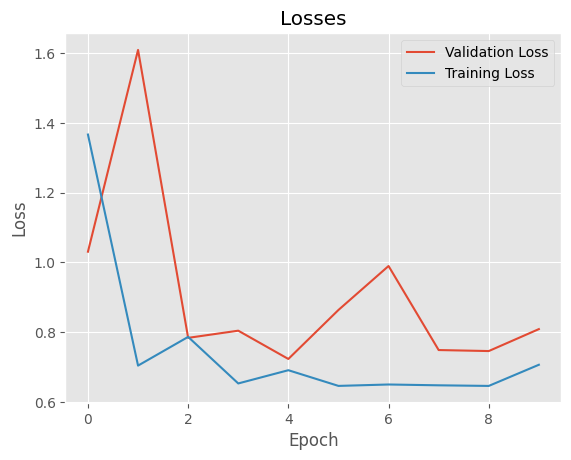

In [15]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.show()

In [16]:
# Load best model trained
resnet50.load_parameters(model.MODEL_FILE_NAME, ctx=ctx)

# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50(images.as_in_context(ctx))
    
    softmax_output = mx.nd.softmax(output.as_nd_ndarray())
    class_output = np.argmax(softmax_output, axis=1)    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

[13:53:56] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


('accuracy', 0.7325)


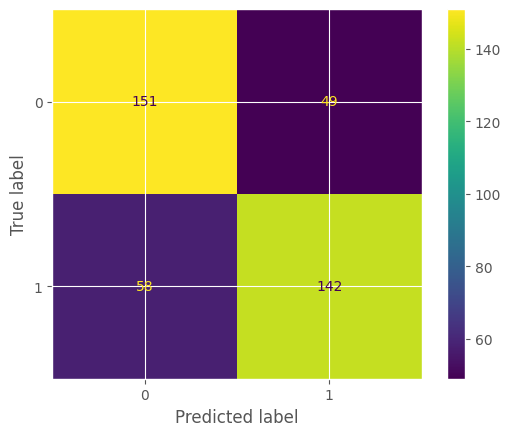

In [17]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()

## Pre-Trained Model

In [18]:
# Back to NumPy Semantics
mx.npx.set_np()

# ResNet50 from Model Zoo (This downloads v1d)
# No Pre-trained weights (training from scratch)
resnet50 = gcv.model_zoo.get_model("resnet50_v1d", pretrained=True, ctx=ctx)

In [19]:
# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50(images.as_in_context(ctx))
    
    class_output_imagenet = np.argmax(output, axis=1)
    class_output = mx.nd.array([model.CLASSES_DICT[idx] for idx in class_output_imagenet.asnumpy()])
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

('accuracy', 0.925)


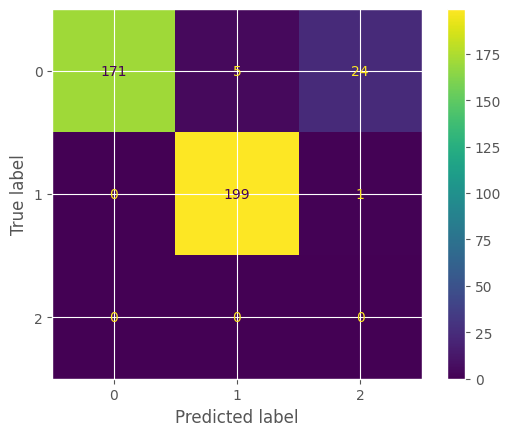

In [20]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()

## Fine-Tuning

In [21]:
import model
reload(model)

# Build on top of Pre-Trained model
resnet50_ft = gcv.model_zoo.get_model("resnet50_v1d", pretrained=True, ctx=ctx)

# Replace the classifier
resnet50_ft.fc = mx.gluon.nn.Dense(2)
resnet50_ft.fc.initialize(ctx=ctx)

# Define Loss Function (Binary, cats vs dogs)
# loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values for full: "adam", lr: 0.01, 10+ epochs, batch size 256
# Optimal values for light: "adam", lr: 0.0001, 10+ epochs, batch size 16
epochs = 10
batch_size = 8

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "adam", {"learning_rate": 0.0001})
# trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "sgd", {"learning_rate": 0.001})

training_loss, training_acc, validation_loss, validation_acc = model.training_loop(resnet50_ft,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

E:    1, TrL: 0.181429, TrAcc: 0.926250, VL: 0.096083, VAcc: 0.960000 --- Updating saved model
E:    2, TrL: 0.069942, TrAcc: 0.975000, VL: 0.071218, VAcc: 0.965000 --- Updating saved model
E:    3, TrL: 0.021615, TrAcc: 0.997500, VL: 0.060663, VAcc: 0.975000 --- Updating saved model
E:    4, TrL: 0.027159, TrAcc: 0.991250, VL: 0.086057, VAcc: 0.950000
E:    5, TrL: 0.039453, TrAcc: 0.987500, VL: 0.083462, VAcc: 0.975000
E:    6, TrL: 0.004860, TrAcc: 1.000000, VL: 0.076389, VAcc: 0.980000 --- Updating saved model
E:    7, TrL: 0.017169, TrAcc: 0.992500, VL: 0.065359, VAcc: 0.975000
E:    8, TrL: 0.034537, TrAcc: 0.992500, VL: 0.126237, VAcc: 0.955000
E:    9, TrL: 0.017967, TrAcc: 0.993750, VL: 0.092691, VAcc: 0.970000
E:   10, TrL: 0.006154, TrAcc: 0.998750, VL: 0.099012, VAcc: 0.960000


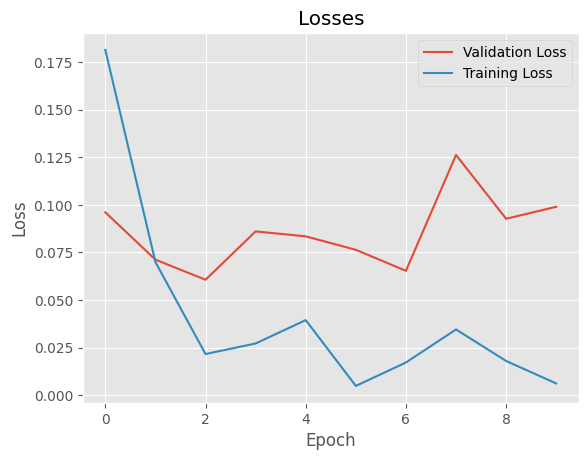

In [22]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.show()

In [23]:
# Load best model trained
resnet50_ft.load_parameters(model.MODEL_FILE_NAME)

# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50_ft(images.as_in_context(ctx))
    
    softmax_output = mx.nd.softmax(output.as_nd_ndarray())
    class_output = np.argmax(softmax_output, axis=1)    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

('accuracy', 0.98)


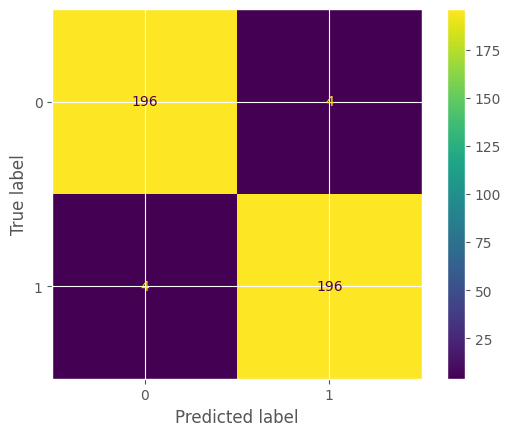

In [24]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()